In [12]:
import numpy as np 
import pandas as pd 

In [13]:
df_state=pd.read_csv('/Users/merrillsequeira/Google Drive/COVID_DATA/statewisetesting/covid_19_india.csv')
df_vax=pd.read_csv('/Users/merrillsequeira/Google Drive/COVID_DATA/statewisetesting/covid_vaccine_statewise.csv')
df_state_testing=pd.read_csv('/Users/merrillsequeira/Google Drive/COVID_DATA/statewisetesting/StatewiseTestingDetails.csv')

In [14]:
df_for=pd.read_csv('/Users/merrillsequeira/Google Drive/COVID_DATA/covid19-global-forecasting-week-4/train.csv') 

In [16]:
df_for.Province_State.fillna("None", inplace=True)
display(df_for.head(5))
display(df_for.describe())
print("Number of Country_Region: ", df_for['Country_Region'].nunique())
print("Dates go from day", max(df_for['Date']), "to day", min(df_for['Date']), ", a total of", df_for['Date'].nunique(), "days")
print("Countries with Province/State informed: ", df_for.loc[df_for['Province_State']!='None']['Country_Region'].unique())

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,None,Afghanistan,2020-01-22,0.0,0.0
1,2,None,Afghanistan,2020-01-23,0.0,0.0
2,3,None,Afghanistan,2020-01-24,0.0,0.0
3,4,None,Afghanistan,2020-01-25,0.0,0.0
4,5,None,Afghanistan,2020-01-26,0.0,0.0


,Id,ConfirmedCases,Fatalities
count,35995.000000,35995.000000,35995.000000
mean,17998.000000,3683.508737,243.560217
std,10391.005806,18986.978708,1832.966999
min,1.000000,0.000000,0.000000
25%,8999.500000,0.000000,0.000000
50%,17998.000000,19.000000,0.000000
75%,26996.500000,543.000000,7.000000
max,35995.000000,345813.000000,33998.000000


Number of Country_Region:  184
Dates go from day 2020-05-15 to day 2020-01-22 , a total of 115 days
Countries with Province/State informed:  ['Australia' 'Canada' 'China' 'Denmark' 'France' 'Netherlands' 'US'
 'United Kingdom']


In [29]:
filt=df_for['Country_Region']=='India'
df2=df_for.loc[filt]

In [37]:
df2.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
16100,16101,None,India,2020-01-22,0.0,0.0
16101,16102,None,India,2020-01-23,0.0,0.0
16102,16103,None,India,2020-01-24,0.0,0.0
16103,16104,None,India,2020-01-25,0.0,0.0
16104,16105,None,India,2020-01-26,0.0,0.0


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')

# ML libraries
# import lightgbm as lgb
#import xgboost as xgb
#from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

Text(0.5, 0, 'Date')

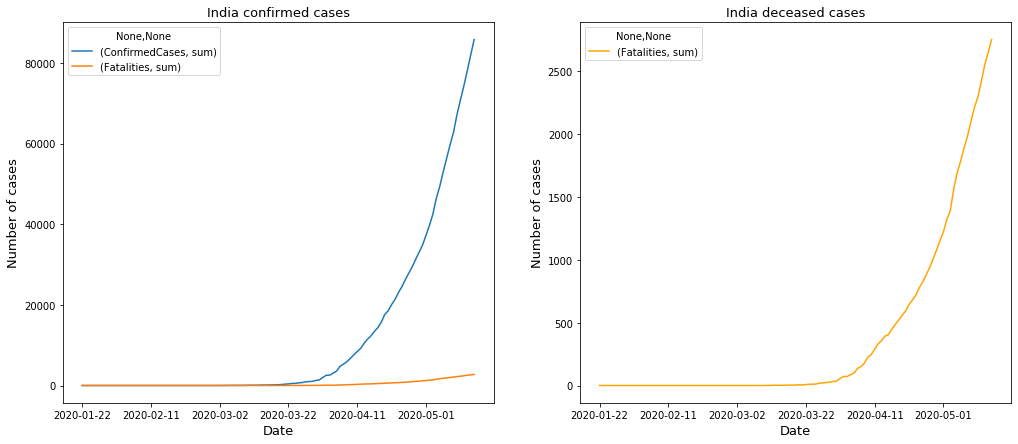

In [20]:
confirmed_total_date_India = df_for[df_for['Country_Region']=='India'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_India = df_for[df_for['Country_Region']=='India'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_India = confirmed_total_date_India.join(fatalities_total_date_India)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date_India.plot(ax=ax1)
ax1.set_title("India confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date_India.plot(ax=ax2, color='orange')
ax2.set_title("India deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

SIR model can be implemented in many ways: from the differential equations governing the system, within a mean field approximation or running the dynamics in a social network (graph). For the sake of simplicity, I'vem chosen the first option, and we will simply run a numerical method (Runge-Kutta) to solve the differential equations system.

The functions governing the dif.eqs. are:

In [21]:

# Susceptible equation
def fa(N, a, b, beta):
    fa = -beta*a*b
    return fa

# Infected equation
def fb(N, a, b, beta, gamma):
    fb = beta*a*b - gamma*b
    return fb

# Recovered/deceased equation
def fc(N, b, gamma):
    fc = gamma*b
    return fc

In [22]:
# Runge-Kutta method of 4rth order for 3 dimensions (susceptible a, infected b and recovered r)
def rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs):
    a1 = fa(N, a, b, beta)*hs
    b1 = fb(N, a, b, beta, gamma)*hs
    c1 = fc(N, b, gamma)*hs
    ak = a + a1*0.5
    bk = b + b1*0.5
    ck = c + c1*0.5
    a2 = fa(N, ak, bk, beta)*hs
    b2 = fb(N, ak, bk, beta, gamma)*hs
    c2 = fc(N, bk, gamma)*hs
    ak = a + a2*0.5
    bk = b + b2*0.5
    ck = c + c2*0.5
    a3 = fa(N, ak, bk, beta)*hs
    b3 = fb(N, ak, bk, beta, gamma)*hs
    c3 = fc(N, bk, gamma)*hs
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(N, ak, bk, beta)*hs
    b4 = fb(N, ak, bk, beta, gamma)*hs
    c4 = fc(N, bk, gamma)*hs
    a = a + (a1 + 2*(a2 + a3) + a4)/6
    b = b + (b1 + 2*(b2 + b3) + b4)/6
    c = c + (c1 + 2*(c2 + c3) + c4)/6
    return a, b, c

In [23]:
def SIR(N, b0, beta, gamma, hs):
    
    """
    N = total number of population
    beta = transition rate S->I
    gamma = transition rate I->R
    k =  denotes the constant degree distribution of the network (average value for networks in which 
    the probability of finding a node with a different connectivity decays exponentially fast
    hs = jump step of the numerical integration
    """
    
    # Initial condition
    a = float(N-1)/N -b0
    b = float(1)/N +b0
    c = 0.

    sus, inf, rec= [],[],[]
    for i in range(10000): # Run for a certain number of time-steps
        sus.append(a)
        inf.append(b)
        rec.append(c)
        a,b,c = rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs)

    return sus, inf, rec

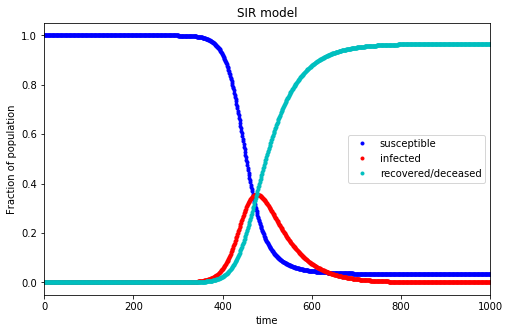

In [24]:
# fitting a test version to world population 


# Parameters of the model
N = 7800*(10**6)
b0 = 0
beta = 0.7
gamma = 0.2
hs = 0.1

sus, inf, rec = SIR(N, b0, beta, gamma, hs)

f = plt.figure(figsize=(8,5)) 
plt.plot(sus, 'b.', label='susceptible');
plt.plot(inf, 'r.', label='infected');
plt.plot(rec, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,1000)
plt.savefig('SIR_example.png')
plt.show()

In [133]:
df2.head() # 2020-01-22 to 2020-05-15


,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
16100,16101,None,India,2020-01-22,0.0,0.0
16101,16102,None,India,2020-01-23,0.0,0.0
16102,16103,None,India,2020-01-24,0.0,0.0
16103,16104,None,India,2020-01-25,0.0,0.0
16104,16105,None,India,2020-01-26,0.0,0.0


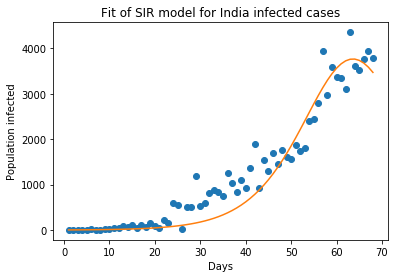

Optimal parameters: beta = 10.39139360402267  and gamma =  10.259857617401726


In [60]:
population = float(46750238)
country_df = pd.DataFrame()
country_df['ConfirmedCases'] = df2.loc[df2['Country_Region']=='India'].ConfirmedCases.diff().fillna(0)
country_df = country_df[47:]
country_df['day_count'] = list(range(1,len(country_df)+1))

ydata = [i for i in country_df.ConfirmedCases]
xdata = country_df.day_count
ydata = np.array(ydata, dtype=float)
xdata = np.array(xdata, dtype=float)

N = population
inf0 = ydata[0]
sus0 = N - inf0
rec0 = 0.0

def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title("Fit of SIR model for India infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

I'm not happy with the fit of parameters and I want to work more on this, since I'm not properly reproducing the curves. I'll keep working on this for curiosity, but in the meanwhile I'll develop a data-centric approach to the prediction.

Text(0, 0.5, 'Log ConfirmedCases')

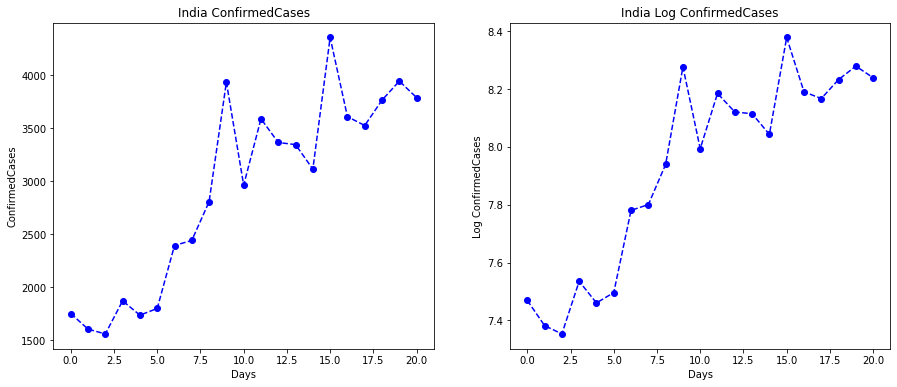

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

# Day_num = 38 is March 1st
y1 = country_df['ConfirmedCases'][47:]
x1 = range(0, len(y1))
ax1.plot(x1, y1, 'bo--')
ax1.set_title("India ConfirmedCases")
ax1.set_xlabel("Days")
ax1.set_ylabel("ConfirmedCases")

y2 = country_df['ConfirmedCases'][47:].apply(lambda x: np.log(x))
x2 = range(0, len(y2))
ax2.plot(x2, y2, 'bo--')
ax2.set_title("India Log ConfirmedCases")
ax2.set_xlabel("Days")
ax2.set_ylabel("Log ConfirmedCases")

In [78]:
from sklearn.linear_model import LinearRegression 

In [79]:
model=LinearRegression(fit_intercept=True)

In [80]:
model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [120]:
#massage the data x into a specific X matrix of n= samples and n-features - ie: reshape the 1 dimensional array x 

# X=df2[45:,:] 
# X.shape
X=df2.iloc[10:,4]
y=df2.iloc[10:,-1]
X=pd.Series()

In [121]:
X.shape


(105,)

In [122]:
y.shape

(105,)

In [125]:
X=np.array(X).reshape(-1,1)
y=np.array(y).reshape(-1,1)


In [126]:
X.shape

(105, 1)

In [127]:
y.shape

(105, 1)

In [128]:
#fit model to data 
model.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [129]:
model.coef_ 

array([[0.03281676]])

In [130]:
model.intercept_

array([-2.48389913])